In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-06-04 00:29:15.161397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import random
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

class DenseLayer:
    def __init__(self, neurons=64, activation='sigmoid'):
        self.neurons = neurons
        self.activation = activation
        self.weights = None
        self.biases = None

    def activation_call(self, x, name, derivative=False):
        if not derivative:
            if name == 'sigmoid':
                return 1 / (1 + np.exp(-x))
            elif name == 'relu':
                return np.maximum(0, x)
        else:
            if name == 'sigmoid':
                sigmoid = 1 / (1 + np.exp(-x))
                return sigmoid * (1 - sigmoid)
            elif name == 'relu':
                return np.where(x > 0, 1, 0)

    def initialize_weights(self, input_size):
        self.weights = np.random.randn(input_size, self.neurons) * 0.01
        self.biases = np.zeros((1, self.neurons))

    def forward(self, X):
        self.input = X
        self.z = np.dot(X, self.weights) + self.biases
        self.output = self.activation_call(self.z, self.activation)
        return self.output

class Densenetwork:
    def __init__(self, alpha=0.001, layers=None, epoch=10, batch_size=5):
        self.alpha = alpha
        self.layers = layers
        self.epoch = epoch
        self.batch_size = batch_size

    def backpropagation(self, X, y, activations, zs):
        m = X.shape[0]
        dA = (activations[-1] - y) / m
        for layer in reversed(range(len(self.layers))):
            dZ = dA * self.layers[layer].activation_call(zs[layer], self.layers[layer].activation, derivative=True)
            dW = np.dot(activations[layer].T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, self.layers[layer].weights.T)
            self.layers[layer].weights -= self.alpha * dW / X.shape[0]
            self.layers[layer].biases -= self.alpha * db / X.shape[0]

    def call(self, X, y=None, training=True):
        if training:
            costs = []
            for epoch in range(self.epoch):
                cost = 0
                for i in range(0, X.shape[0], self.batch_size):
                    X_batch = X[i:i+self.batch_size]
                    y_batch = y[i:i+self.batch_size]
                    activations = [X_batch]
                    zs = []
                    for layer in self.layers:
                        if layer.weights is None:
                            layer.initialize_weights(activations[-1].shape[1])
                        z = layer.forward(activations[-1])
                        zs.append(z)
                        activations.append(z)
                    cost += np.mean((activations[-1] - y_batch) ** 2)
                    self.backpropagation(X_batch, y_batch, activations, zs)
                cost /= X.shape[0]
                costs.append(cost)
                print(f"Epoch {epoch+1}/{self.epoch}, Loss: {cost}")
            return costs
        else:
            activations = [X]
            for layer in self.layers:
                activations.append(layer.forward(activations[-1]))
            return activations[-1]


X, y = make_regression(n_samples=100, n_features=20, noise=0.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

layers = [DenseLayer(neurons=60, activation='relu'),
          DenseLayer(neurons=100, activation='sigmoid'),
          DenseLayer(neurons=1, activation='sigmoid')]

network = Densenetwork(layers=layers, alpha=0.1, epoch=20, batch_size=5)
costs = network.call(X_train, y_train)
predictions = network.call(X_test, training=False)


Epoch 1/20, Loss: 6460.584902641087
Epoch 2/20, Loss: 6458.605043875994
Epoch 3/20, Loss: 6459.378628035255
Epoch 4/20, Loss: 6459.304252314304
Epoch 5/20, Loss: 6459.265385436985
Epoch 6/20, Loss: 6459.2621703156165
Epoch 7/20, Loss: 6459.262392753264
Epoch 8/20, Loss: 6459.261678978537
Epoch 9/20, Loss: 6459.261712161215
Epoch 10/20, Loss: 6459.261672128022
Epoch 11/20, Loss: 6459.261673989012
Epoch 12/20, Loss: 6459.261671743847
Epoch 13/20, Loss: 6459.261671778872
Epoch 14/20, Loss: 6459.261671733299
Epoch 15/20, Loss: 6459.261671722033
Epoch 16/20, Loss: 6459.261671721737
Epoch 17/20, Loss: 6459.261671721057
Epoch 18/20, Loss: 6459.261671721042
Epoch 19/20, Loss: 6459.261671721026
Epoch 20/20, Loss: 6459.261671721022


/var/folders/9f/r8h0fl6158l8g2_8l65x2zv00000gn/T/ipykernel_63111/2315777841.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


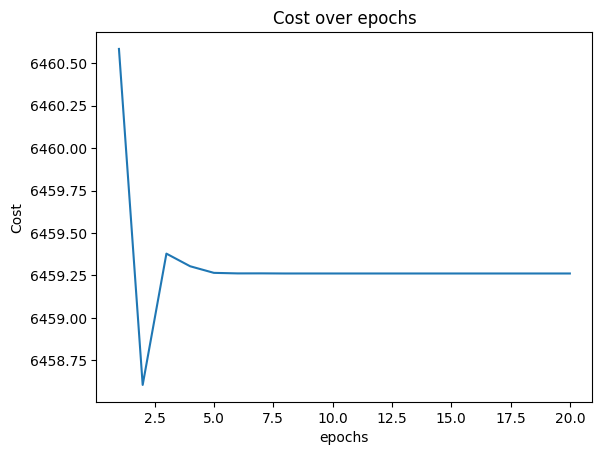

In [3]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(costs) + 1), costs)
plt.xlabel('epochs')
plt.ylabel('Cost')
plt.title('Cost over epochs')
plt.show()

In [4]:
import tensorflow as tf

class CustomDense(tf.Module):
    def __init__(self, input_dim, output_dim, activation=None):
        super(CustomDense, self).__init__()
        self.weights = tf.Variable(tf.random.normal([input_dim, output_dim]))
        self.biases = tf.Variable(tf.random.normal([output_dim]))
        self.activation = activation

    def __call__(self, x):
        z = tf.matmul(x, self.weights) + self.biases
        if self.activation == 'relu':
            return tf.nn.relu(z)
        elif self.activation == 'sigmoid':
            return tf.nn.sigmoid(z)
        else:
            return z

    def get_trainable_variables(self):
        return [self.weights, self.biases]

class CustomNetwork(tf.Module):
    def __init__(self, input_dim, hidden_units, output_units, activations):
        super(CustomNetwork, self).__init__()
        self.layers = []
        self.activations = activations

    
        for i, units in enumerate(hidden_units):
            layer = CustomDense(input_dim, units, activation=activations[i])
            self.layers.append(layer)
            input_dim = units

   
        self.output_layer = CustomDense(input_dim, output_units, activation=activations[-1])

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

    def get_trainable_variables(self):
        trainable_variables = []
        for layer in self.layers:
            trainable_variables.extend(layer.get_trainable_variables())
        trainable_variables.extend(self.output_layer.get_trainable_variables())
        return trainable_variables



input_dim = 2
hidden_units = [4, 3]
output_units = 1
activations = ['relu', 'relu', 'sigmoid']
network = CustomNetwork(input_dim, hidden_units, output_units, activations)


x = tf.constant([[0.2, 0.4], [0.6, 0.8]])

output = network(x)
print(output)


tf.Tensor(
[[0.85525084]
 [0.82115436]], shape=(2, 1), dtype=float32)


# below commented Code is other  version of backpropogation 
if possible can you give me feedback
Thanks in advance

In [5]:
# import random
# import numpy as np

# class DenseLayer:
#     def __init__(self, neurons=64, activation='sigmoid'):
#         self.neurons = neurons
#         self.activation = activation

#     def activation_call(self, x, name, derivative=False):
#         if not derivative:
#             if name == 'sigmoid':
#                 return 1 / (1 + np.exp(-x))
#             elif name == 'relu':
#                 return np.maximum(0, x)
#         else:
#             if name == 'sigmoid':
#                 sigmoid = 1 / (1 + np.exp(-x))
#                 return sigmoid * (1 - sigmoid)
#             elif name == 'relu':
#                 return np.where(x > 0, 1, 0)

#     def Forward(self, X):
#         weight = np.random.randn(X.shape[1], self.neurons)
#         bias = np.zeros(self.neurons)
#         z = (np.dot(X, weight) + bias).T
#         activation = (self.activation_call(z, self.activation)).T
#         return activation, z


# class Densenetwork:
#     def __init__(self, alpha=0.1, layers=[], epoch=10, batch_size=5):
#         self.alpha = alpha
#         self.epoch = epoch
#         self.layers = layers
#         self.batch_size = batch_size
#         self.weights = []
#         self.biases = []

#     def backpropagation(self, X, y, activations, zs):
#         deltas = [None] * len(self.layers)
#         gradients = [None] * (len(self.layers) )

#         deltas[-1] = (activations[-1] - y) * self.layers[-1].activation_call(zs[-1], name=self.layers[-1].activation,
#                                                                               derivative=True).T
#         for i in range(len(self.layers) - 2, 0, -1):
#             deltas[i] = np.dot(self.weights[i + 1], deltas[i + 1].T) * self.layers[i].activation_call(zs[i],
#                                                                                                         name=self.layers[
#                                                                                                             i].activation,
#                                                                                                         derivative=True)
#         i -= 1
#         deltas[i] = np.dot(self.weights[i + 1], deltas[i + 1]) * self.layers[i].activation_call(zs[i],
#                                                                                                  name=self.layers[
#                                                                                                      i].activation,
#                                                                                                  derivative=True)

#         for i in range(len(self.layers) - 1):
#             gradient_w = np.dot(deltas[i], activations[i])
#             gradient_b = np.sum(deltas[i + 1], axis=1, keepdims=True)

#             self.weights[i] = self.weights[i] - self.alpha * gradient_w.T
#             self.biases[i] = self.biases[i] - self.alpha * gradient_b

#     def init_weights(self, X, y):
#         input_shape = X.shape[1]
#         init_w = []
#         init_b = []
#         output_shape = self.layers[0].neurons
#         std = 2 / (input_shape + output_shape)
#         init_w.append(np.random.uniform(low=0, high=std, size=[input_shape, output_shape]))
#         init_b.append(np.random.uniform(low=0, high=std, size=[output_shape, 1]))
#         for i in range(len(self.layers) - 1):
#             input_shape = self.layers[i].neurons
#             output_shape = self.layers[i + 1].neurons
#             std = 2 / (input_shape + output_shape)
#             init_w.append(np.random.uniform(low=0, high=std, size=[input_shape, output_shape]))
#             init_b.append(np.random.uniform(low=0, high=std, size=[output_shape, 1]))
#         output_shape = self.layers[-1].neurons
#         std = 2 / (output_shape + y.shape[0])
#         init_w.append(np.random.uniform(low=0, high=std, size=[output_shape, y.shape[0]]))
#         init_b.append(np.random.uniform(low=0, high=std, size=[output_shape, 1]))
#         self.weights = init_w
#         init_b.reverse()
#         self.biases = init_b

#     def call(self, X, y=None, training=True):
#         costs = []
#         if training:
#             for epoch in range(self.epoch):
#                 num_batches = X.shape[1] // self.batch_size
#                 indices = np.arange(X.shape[1])
#                 np.random.shuffle(indices)

#                 for batch in range(num_batches):
#                     start = batch * self.batch_size
#                     end = start + self.batch_size
#                     batch_indices = indices[start:end]
#                     X_batch = X[batch_indices, :]
#                     y_batch = y[batch_indices, :]
#                     if batch == 0:
#                         self.init_weights(X_batch, y_batch)
#                     all_layers = [X_batch]
#                     zs = []

#                     for i in range(len(self.layers)):
#                         activation, z = self.layers[i].Forward(all_layers[-1])
#                         all_layers.append(activation)
#                         zs.append(z)
#                     self.backpropagation(X_batch, y_batch, all_layers, zs)
#                 cost = np.mean(np.square(all_layers[-1] - y_batch))
#                 print(f"Epoch {epoch}: Cost = {cost}")
#                 costs.append(cost)
#             else:
#                 return costs

# from sklearn.datasets import make_regression

# # Generate synthetic dataset
# X, y = make_regression(n_samples=100, n_features=20, noise=0.5, random_state=42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)

# layers = [DenseLayer(neurons=60, activation='relu'), DenseLayer(neurons=32, activation='sigmoid'), DenseLayer(neurons=1, activation='sigmoid')]

# n = Densenetwork(layers= layers , alpha = 10, epoch = 100)
# a = n.call(X_train ,y_train )